In [25]:
import numpy as np
import corner

In [133]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = plt.cm.get_cmap('viridis_r')
#cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

## Load data

In [206]:
betas = np.load("../data/betas.npy")
hods = np.load("../data/hods.npy")[:, :-2]
fit_betas = np.load("../data/fit_betas_P+B.npy").T

betas.shape, hods.shape, fit_betas.shape

((10500, 5, 127), (10500, 8), (10500, 6))

## Train density estimators

In [207]:
import torch

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from tqdm import tqdm

In [208]:
val_fraction = 0.05

# Get train and validation sets
n_samples = len(fit_betas)
n_val = int(val_fraction * n_samples)
n_train = n_samples - n_val

# Shuffle data
shuffler = np.random.permutation(n_samples)
fit_betas = fit_betas[shuffler]
hods = hods[shuffler]

X_train = torch.tensor(fit_betas[:n_train], dtype=torch.float32)
Y_train = torch.tensor(hods[:n_train], dtype=torch.float32)

X_val = torch.tensor(fit_betas[n_train:], dtype=torch.float32)
Y_val = torch.tensor(hods[n_train:], dtype=torch.float32)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

(torch.Size([9975, 6]),
 torch.Size([9975, 8]),
 torch.Size([525, 6]),
 torch.Size([525, 8]))

In [209]:
import torch.nn.functional as F

def get_flow(d_in=2, d_context=12, d_hidden=32, n_layers=4, dropout=0.1):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, 
                                                              hidden_features=d_hidden,
                                                              context_features=d_context,
                                                              use_residual_blocks=True,
                                                              dropout_probability=dropout,
                                                              activation=F.gelu))
        
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

In [210]:
def train_flow(flow, X, Y, X_val, Y_val, batch_size=64, n_steps=5001, n_eval_every=100, lr = 1e-3):
    """ Convenience function for training the normalizing flow transformation
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

    loss_train = []
    
    loss_train_accum = []
    loss_val_accum = []
    steps_accum = []

    # Run specified number of optimization steps
    for i_step in tqdm(range(n_steps)):
        
        optimizer.zero_grad()
        
        # Draw random batches and compute their log-probability
        idxs = np.random.choice(X.shape[0], batch_size) 
        if Y is not None:
            loss = -flow.log_prob(X[idxs,:], Y[idxs,:]).mean()
        else:
            loss = -flow.log_prob(X[idxs,:]).mean()

        loss.backward()
        optimizer.step()

        # Store loss
        loss_train.append(loss.item())

        # Print progress and validation loss
        if i_step % n_eval_every == 0:
            if Y is not None:
                loss_val = -flow.log_prob(X_val, Y_val).mean()
            else:
                loss_val = -flow.log_prob(X_val).mean()

            loss_train_accum.append(np.mean(loss_train))
            loss_val_accum.append(loss_val.item())
            steps_accum.append(i_step)

            print(f"Step {i_step}, loss: {np.mean(loss_train):.2f}, val loss: {loss_val.item():.2f}")

            loss_train = []

    return steps_accum, loss_train_accum, loss_val_accum
        

## $p(\beta\mid\mathrm{HOD})$

In [219]:
d_in = X_train.shape[-1]
d_context = Y_train.shape[-1]

flow = get_flow(d_in=d_in, d_context=d_context, d_hidden=128, n_layers=6, dropout=0.1)

In [220]:
steps_accum, loss_train_accum, loss_val_accum = train_flow(flow, X_train, Y_train, X_val, Y_val, batch_size=128, n_steps=50001, n_eval_every=200, lr=3e-4)

  0%|          | 9/50001 [00:00<17:50, 46.70it/s]

Step 0, loss: 31.19, val loss: 24.75


  0%|          | 214/50001 [00:03<12:29, 66.46it/s]

Step 200, loss: 0.54, val loss: -2.87


  1%|          | 413/50001 [00:05<11:39, 70.94it/s]

Step 400, loss: -3.56, val loss: -4.60


  1%|          | 613/50001 [00:08<11:35, 70.97it/s]

Step 600, loss: -4.52, val loss: -3.82


  2%|▏         | 813/50001 [00:11<11:38, 70.44it/s]

Step 800, loss: -5.38, val loss: -6.36


  2%|▏         | 1012/50001 [00:14<11:35, 70.41it/s]

Step 1000, loss: -5.98, val loss: -6.69


  2%|▏         | 1212/50001 [00:17<11:26, 71.07it/s]

Step 1200, loss: -3.16, val loss: -6.43


  3%|▎         | 1412/50001 [00:20<11:10, 72.42it/s]

Step 1400, loss: -6.48, val loss: -6.94


  3%|▎         | 1612/50001 [00:22<11:17, 71.39it/s]

Step 1600, loss: -6.89, val loss: -7.65


  4%|▎         | 1812/50001 [00:25<11:32, 69.56it/s]

Step 1800, loss: -7.32, val loss: -7.89


  4%|▍         | 2008/50001 [00:28<12:33, 63.72it/s]

Step 2000, loss: -7.57, val loss: -8.15


  4%|▍         | 2215/50001 [00:31<11:11, 71.12it/s]

Step 2200, loss: -7.84, val loss: -7.67


  5%|▍         | 2415/50001 [00:34<11:02, 71.83it/s]

Step 2400, loss: -8.06, val loss: -8.64


  5%|▌         | 2611/50001 [00:36<12:49, 61.60it/s]

Step 2600, loss: -8.19, val loss: -7.67


  6%|▌         | 2809/50001 [00:39<11:01, 71.30it/s]

Step 2800, loss: -8.35, val loss: -8.80


  6%|▌         | 3009/50001 [00:42<11:20, 69.06it/s]

Step 3000, loss: -8.59, val loss: -8.85


  6%|▋         | 3208/50001 [00:45<11:41, 66.73it/s]

Step 3200, loss: -8.52, val loss: -9.16


  7%|▋         | 3408/50001 [00:47<11:13, 69.21it/s]

Step 3400, loss: -8.73, val loss: -9.38


  7%|▋         | 3608/50001 [00:50<10:48, 71.54it/s]

Step 3600, loss: -8.93, val loss: -8.98


  8%|▊         | 3811/50001 [00:53<11:02, 69.75it/s]

Step 3800, loss: -9.00, val loss: -9.37


  8%|▊         | 4009/50001 [00:56<10:46, 71.14it/s]

Step 4000, loss: -8.90, val loss: -9.45


  8%|▊         | 4209/50001 [00:59<11:06, 68.74it/s]

Step 4200, loss: -9.10, val loss: -9.45


  9%|▉         | 4413/50001 [01:02<10:50, 70.06it/s]

Step 4400, loss: -9.29, val loss: -9.06


  9%|▉         | 4609/50001 [01:04<10:32, 71.77it/s]

Step 4600, loss: -9.37, val loss: -9.78


 10%|▉         | 4809/50001 [01:07<10:28, 71.91it/s]

Step 4800, loss: -9.39, val loss: -9.76


 10%|█         | 5009/50001 [01:10<10:19, 72.64it/s]

Step 5000, loss: -9.47, val loss: -9.71


 10%|█         | 5209/50001 [01:12<10:15, 72.81it/s]

Step 5200, loss: -9.47, val loss: -9.69


 11%|█         | 5409/50001 [01:15<10:16, 72.35it/s]

Step 5400, loss: -9.49, val loss: -9.98


 11%|█         | 5609/50001 [01:18<10:20, 71.55it/s]

Step 5600, loss: -9.64, val loss: -10.16


 12%|█▏        | 5809/50001 [01:21<10:15, 71.83it/s]

Step 5800, loss: -9.75, val loss: -10.11


 12%|█▏        | 6009/50001 [01:24<10:27, 70.15it/s]

Step 6000, loss: -9.74, val loss: -10.13


 12%|█▏        | 6209/50001 [01:26<10:44, 67.93it/s]

Step 6200, loss: -9.79, val loss: -10.39


 13%|█▎        | 6415/50001 [01:29<10:27, 69.42it/s]

Step 6400, loss: -9.88, val loss: -10.00


 13%|█▎        | 6615/50001 [01:32<10:09, 71.19it/s]

Step 6600, loss: -9.93, val loss: -10.33


 14%|█▎        | 6815/50001 [01:35<10:09, 70.83it/s]

Step 6800, loss: -9.94, val loss: -10.42


 14%|█▍        | 7015/50001 [01:38<09:57, 71.89it/s]

Step 7000, loss: -10.01, val loss: -10.31


 14%|█▍        | 7215/50001 [01:40<09:54, 72.01it/s]

Step 7200, loss: -10.04, val loss: -10.38


 15%|█▍        | 7415/50001 [01:43<09:59, 71.03it/s]

Step 7400, loss: -10.07, val loss: -9.95


 15%|█▌        | 7615/50001 [01:46<09:48, 72.06it/s]

Step 7600, loss: -10.06, val loss: -10.21


 16%|█▌        | 7812/50001 [01:49<10:24, 67.53it/s]

Step 7800, loss: -10.16, val loss: -10.63


 16%|█▌        | 8009/50001 [01:51<09:46, 71.59it/s]

Step 8000, loss: -10.12, val loss: -10.58


 16%|█▋        | 8208/50001 [01:54<10:14, 68.02it/s]

Step 8200, loss: -10.34, val loss: -10.47


 17%|█▋        | 8415/50001 [01:57<09:50, 70.47it/s]

Step 8400, loss: -10.22, val loss: -9.93


 17%|█▋        | 8614/50001 [02:00<09:57, 69.29it/s]

Step 8600, loss: -10.29, val loss: -10.81


 18%|█▊        | 8814/50001 [02:03<09:54, 69.32it/s]

Step 8800, loss: -10.40, val loss: -10.49


 18%|█▊        | 9014/50001 [02:06<09:34, 71.39it/s]

Step 9000, loss: -10.45, val loss: -10.60


 18%|█▊        | 9214/50001 [02:08<09:45, 69.67it/s]

Step 9200, loss: -10.49, val loss: -10.34


 19%|█▉        | 9412/50001 [02:11<09:57, 67.93it/s]

Step 9400, loss: -10.51, val loss: -10.02


 19%|█▉        | 9612/50001 [02:14<09:20, 72.01it/s]

Step 9600, loss: -10.43, val loss: -10.78


 20%|█▉        | 9812/50001 [02:17<09:18, 71.95it/s]

Step 9800, loss: -10.55, val loss: -11.00


 20%|██        | 10012/50001 [02:19<09:27, 70.41it/s]

Step 10000, loss: -10.56, val loss: -10.88


 20%|██        | 10211/50001 [02:22<09:30, 69.75it/s]

Step 10200, loss: -10.60, val loss: -10.78


 21%|██        | 10410/50001 [02:25<09:27, 69.73it/s]

Step 10400, loss: -10.55, val loss: -10.81


 21%|██        | 10614/50001 [02:28<10:10, 64.56it/s]

Step 10600, loss: -10.71, val loss: -10.97


 22%|██▏       | 10814/50001 [02:31<09:20, 69.88it/s]

Step 10800, loss: -10.71, val loss: -10.90


 22%|██▏       | 11012/50001 [02:34<09:05, 71.42it/s]

Step 11000, loss: -10.75, val loss: -10.81


 22%|██▏       | 11212/50001 [02:36<09:05, 71.11it/s]

Step 11200, loss: -10.81, val loss: -11.03


 23%|██▎       | 11412/50001 [02:39<09:05, 70.76it/s]

Step 11400, loss: -10.82, val loss: -11.19


 23%|██▎       | 11612/50001 [02:42<08:56, 71.58it/s]

Step 11600, loss: -10.82, val loss: -11.24


 24%|██▎       | 11812/50001 [02:45<08:52, 71.75it/s]

Step 11800, loss: -10.86, val loss: -10.95


 24%|██▍       | 12011/50001 [02:47<09:08, 69.32it/s]

Step 12000, loss: -10.90, val loss: -10.83


 24%|██▍       | 12211/50001 [02:50<08:42, 72.32it/s]

Step 12200, loss: -10.88, val loss: -11.21


 25%|██▍       | 12411/50001 [02:53<08:42, 71.88it/s]

Step 12400, loss: -11.00, val loss: -11.28


 25%|██▌       | 12611/50001 [02:56<08:40, 71.90it/s]

Step 12600, loss: -10.98, val loss: -11.35


 26%|██▌       | 12811/50001 [02:58<08:38, 71.67it/s]

Step 12800, loss: -11.02, val loss: -11.02


 26%|██▌       | 13011/50001 [03:01<08:37, 71.53it/s]

Step 13000, loss: -10.94, val loss: -11.14


 26%|██▋       | 13211/50001 [03:04<08:32, 71.83it/s]

Step 13200, loss: -11.10, val loss: -11.17


 27%|██▋       | 13411/50001 [03:07<08:28, 71.92it/s]

Step 13400, loss: -11.11, val loss: -11.25


 27%|██▋       | 13610/50001 [03:09<08:27, 71.72it/s]

Step 13600, loss: -11.13, val loss: -11.17


 28%|██▊       | 13810/50001 [03:12<08:25, 71.65it/s]

Step 13800, loss: -11.12, val loss: -10.68


 28%|██▊       | 14010/50001 [03:15<08:23, 71.47it/s]

Step 14000, loss: -11.11, val loss: -11.41


 28%|██▊       | 14210/50001 [03:18<08:18, 71.85it/s]

Step 14200, loss: -11.18, val loss: -11.37


 29%|██▉       | 14410/50001 [03:20<08:14, 71.94it/s]

Step 14400, loss: -11.24, val loss: -10.87


 29%|██▉       | 14615/50001 [03:23<08:15, 71.39it/s]

Step 14600, loss: -11.20, val loss: -11.36


 30%|██▉       | 14815/50001 [03:26<08:11, 71.65it/s]

Step 14800, loss: -11.17, val loss: -11.25


 30%|███       | 15015/50001 [03:29<08:12, 71.10it/s]

Step 15000, loss: -11.24, val loss: -11.18


 30%|███       | 15215/50001 [03:32<08:03, 71.98it/s]

Step 15200, loss: -11.28, val loss: -11.55


 31%|███       | 15415/50001 [03:34<08:02, 71.72it/s]

Step 15400, loss: -11.32, val loss: -11.51


 31%|███       | 15615/50001 [03:37<08:00, 71.63it/s]

Step 15600, loss: -11.30, val loss: -11.35


 32%|███▏      | 15815/50001 [03:40<07:54, 72.10it/s]

Step 15800, loss: -11.36, val loss: -11.73


 32%|███▏      | 16014/50001 [03:43<08:23, 67.44it/s]

Step 16000, loss: -11.40, val loss: -11.43


 32%|███▏      | 16213/50001 [03:45<07:54, 71.21it/s]

Step 16200, loss: -11.42, val loss: -11.33


 33%|███▎      | 16413/50001 [03:48<07:49, 71.60it/s]

Step 16400, loss: -11.40, val loss: -11.75


 33%|███▎      | 16613/50001 [03:51<07:45, 71.71it/s]

Step 16600, loss: -11.45, val loss: -11.55


 34%|███▎      | 16813/50001 [03:54<07:44, 71.47it/s]

Step 16800, loss: -11.47, val loss: -11.62


 34%|███▍      | 17013/50001 [03:56<07:42, 71.38it/s]

Step 17000, loss: -11.46, val loss: -11.57


 34%|███▍      | 17213/50001 [03:59<07:36, 71.82it/s]

Step 17200, loss: -11.50, val loss: -11.68


 35%|███▍      | 17413/50001 [04:02<08:01, 67.74it/s]

Step 17400, loss: -11.41, val loss: -11.62


 35%|███▌      | 17612/50001 [04:05<07:31, 71.78it/s]

Step 17600, loss: -11.53, val loss: -11.68


 36%|███▌      | 17812/50001 [04:07<07:28, 71.84it/s]

Step 17800, loss: -11.53, val loss: -11.82


 36%|███▌      | 18012/50001 [04:10<07:26, 71.62it/s]

Step 18000, loss: -11.49, val loss: -11.64


 36%|███▋      | 18211/50001 [04:13<07:24, 71.46it/s]

Step 18200, loss: -11.55, val loss: -11.62


 37%|███▋      | 18411/50001 [04:16<07:33, 69.65it/s]

Step 18400, loss: -11.57, val loss: -11.76


 37%|███▋      | 18614/50001 [04:19<07:31, 69.51it/s]

Step 18600, loss: -11.59, val loss: -11.93


 38%|███▊      | 18813/50001 [04:22<07:20, 70.76it/s]

Step 18800, loss: -11.67, val loss: -11.82


 38%|███▊      | 19013/50001 [04:24<07:04, 72.96it/s]

Step 19000, loss: -11.73, val loss: -11.80


 38%|███▊      | 19213/50001 [04:27<07:06, 72.16it/s]

Step 19200, loss: -11.66, val loss: -11.96


 39%|███▉      | 19413/50001 [04:30<07:08, 71.46it/s]

Step 19400, loss: -11.66, val loss: -11.41


 39%|███▉      | 19613/50001 [04:33<06:55, 73.08it/s]

Step 19600, loss: -11.74, val loss: -11.73


 40%|███▉      | 19812/50001 [04:35<07:43, 65.08it/s]

Step 19800, loss: -11.72, val loss: -12.08


 40%|████      | 20011/50001 [04:38<06:55, 72.21it/s]

Step 20000, loss: -11.79, val loss: -11.56


 40%|████      | 20211/50001 [04:41<06:50, 72.50it/s]

Step 20200, loss: -11.74, val loss: -11.87


 41%|████      | 20411/50001 [04:44<06:50, 72.17it/s]

Step 20400, loss: -11.88, val loss: -11.56


 41%|████      | 20611/50001 [04:46<06:42, 72.98it/s]

Step 20600, loss: -11.82, val loss: -12.10


 42%|████▏     | 20811/50001 [04:49<06:40, 72.83it/s]

Step 20800, loss: -11.87, val loss: -12.15


 42%|████▏     | 21011/50001 [04:52<06:34, 73.40it/s]

Step 21000, loss: -11.85, val loss: -12.16


 42%|████▏     | 21211/50001 [04:54<06:36, 72.53it/s]

Step 21200, loss: -11.80, val loss: -12.07


 43%|████▎     | 21411/50001 [04:57<06:35, 72.33it/s]

Step 21400, loss: -12.00, val loss: -11.91


 43%|████▎     | 21611/50001 [05:00<06:29, 72.85it/s]

Step 21600, loss: -11.93, val loss: -12.24


 44%|████▎     | 21811/50001 [05:03<06:42, 70.09it/s]

Step 21800, loss: -11.98, val loss: -11.58


 44%|████▍     | 22011/50001 [05:06<07:13, 64.57it/s]

Step 22000, loss: -12.05, val loss: -11.70


 44%|████▍     | 22208/50001 [05:08<06:32, 70.89it/s]

Step 22200, loss: -11.96, val loss: -11.99


 45%|████▍     | 22416/50001 [05:11<06:18, 72.94it/s]

Step 22400, loss: -12.05, val loss: -12.27


 45%|████▌     | 22615/50001 [05:14<06:22, 71.59it/s]

Step 22600, loss: -12.12, val loss: -12.41


 46%|████▌     | 22815/50001 [05:17<06:14, 72.51it/s]

Step 22800, loss: -12.21, val loss: -12.35


 46%|████▌     | 23015/50001 [05:19<06:02, 74.39it/s]

Step 23000, loss: -12.23, val loss: -12.51


 46%|████▋     | 23208/50001 [05:22<06:18, 70.72it/s]

Step 23200, loss: -12.20, val loss: -11.78


 47%|████▋     | 23415/50001 [05:25<06:12, 71.35it/s]

Step 23400, loss: -12.27, val loss: -12.54


 47%|████▋     | 23615/50001 [05:28<06:07, 71.84it/s]

Step 23600, loss: -12.40, val loss: -12.46


 48%|████▊     | 23815/50001 [05:30<06:02, 72.30it/s]

Step 23800, loss: -12.43, val loss: -12.30


 48%|████▊     | 24015/50001 [05:33<06:00, 72.17it/s]

Step 24000, loss: -12.50, val loss: -12.77


 48%|████▊     | 24215/50001 [05:36<05:58, 72.02it/s]

Step 24200, loss: -12.50, val loss: -11.87


 49%|████▉     | 24415/50001 [05:39<05:55, 71.89it/s]

Step 24400, loss: -12.56, val loss: -12.49


 49%|████▉     | 24615/50001 [05:41<05:50, 72.40it/s]

Step 24600, loss: -12.67, val loss: -12.79


 50%|████▉     | 24815/50001 [05:44<05:47, 72.38it/s]

Step 24800, loss: -12.67, val loss: -12.84


 50%|█████     | 25015/50001 [05:47<05:45, 72.40it/s]

Step 25000, loss: -12.73, val loss: -12.58


 50%|█████     | 25215/50001 [05:49<05:45, 71.68it/s]

Step 25200, loss: -12.59, val loss: -12.90


 51%|█████     | 25414/50001 [05:52<06:02, 67.78it/s]

Step 25400, loss: -12.84, val loss: -13.13


 51%|█████     | 25613/50001 [05:55<05:40, 71.54it/s]

Step 25600, loss: -12.83, val loss: -12.62


 52%|█████▏    | 25813/50001 [05:58<05:33, 72.57it/s]

Step 25800, loss: -12.83, val loss: -13.11


 52%|█████▏    | 26013/50001 [06:00<05:30, 72.58it/s]

Step 26000, loss: -12.95, val loss: -12.93


 52%|█████▏    | 26213/50001 [06:03<05:30, 71.91it/s]

Step 26200, loss: -12.98, val loss: -13.18


 53%|█████▎    | 26413/50001 [06:06<05:26, 72.22it/s]

Step 26400, loss: -13.01, val loss: -11.59


 53%|█████▎    | 26613/50001 [06:09<05:25, 71.93it/s]

Step 26600, loss: -12.99, val loss: -12.69


 54%|█████▎    | 26813/50001 [06:11<05:20, 72.41it/s]

Step 26800, loss: -13.03, val loss: -13.35


 54%|█████▍    | 27013/50001 [06:14<05:18, 72.22it/s]

Step 27000, loss: -13.12, val loss: -13.38


 54%|█████▍    | 27213/50001 [06:17<05:15, 72.20it/s]

Step 27200, loss: -13.09, val loss: -12.89


 55%|█████▍    | 27414/50001 [06:20<05:30, 68.28it/s]

Step 27400, loss: -13.14, val loss: -13.18


 55%|█████▌    | 27615/50001 [06:23<05:18, 70.35it/s]

Step 27600, loss: -13.13, val loss: -13.32


 56%|█████▌    | 27814/50001 [06:25<05:11, 71.12it/s]

Step 27800, loss: -13.21, val loss: -13.04


 56%|█████▌    | 28014/50001 [06:28<05:10, 70.92it/s]

Step 28000, loss: -13.23, val loss: -13.57


 56%|█████▋    | 28214/50001 [06:31<05:04, 71.60it/s]

Step 28200, loss: -13.26, val loss: -13.37


 57%|█████▋    | 28414/50001 [06:34<05:00, 71.80it/s]

Step 28400, loss: -13.27, val loss: -13.65


 57%|█████▋    | 28614/50001 [06:37<05:18, 67.12it/s]

Step 28600, loss: -13.27, val loss: -13.58


 58%|█████▊    | 28813/50001 [06:39<05:00, 70.58it/s]

Step 28800, loss: -13.26, val loss: -13.64


 58%|█████▊    | 29012/50001 [06:42<05:03, 69.12it/s]

Step 29000, loss: -13.26, val loss: -13.60


 58%|█████▊    | 29210/50001 [06:45<04:48, 71.94it/s]

Step 29200, loss: -13.43, val loss: -13.43


 59%|█████▉    | 29410/50001 [06:48<04:51, 70.61it/s]

Step 29400, loss: -13.37, val loss: -13.65


 59%|█████▉    | 29610/50001 [06:50<04:43, 71.91it/s]

Step 29600, loss: -13.38, val loss: -13.74


 60%|█████▉    | 29810/50001 [06:53<04:49, 69.68it/s]

Step 29800, loss: -13.56, val loss: -12.40


 60%|██████    | 30010/50001 [06:56<04:38, 71.84it/s]

Step 30000, loss: -13.42, val loss: -12.97


 60%|██████    | 30210/50001 [06:59<04:31, 72.77it/s]

Step 30200, loss: -13.55, val loss: -13.32


 61%|██████    | 30410/50001 [07:01<04:31, 72.15it/s]

Step 30400, loss: -13.46, val loss: -13.62


 61%|██████    | 30610/50001 [07:04<04:25, 73.02it/s]

Step 30600, loss: -13.58, val loss: -13.67


 62%|██████▏   | 30810/50001 [07:07<04:25, 72.35it/s]

Step 30800, loss: -13.52, val loss: -13.84


 62%|██████▏   | 31010/50001 [07:09<04:24, 71.69it/s]

Step 31000, loss: -13.59, val loss: -13.76


 62%|██████▏   | 31210/50001 [07:12<04:19, 72.36it/s]

Step 31200, loss: -13.60, val loss: -13.85


 63%|██████▎   | 31410/50001 [07:15<04:17, 72.24it/s]

Step 31400, loss: -13.53, val loss: -13.47


 63%|██████▎   | 31610/50001 [07:18<04:13, 72.53it/s]

Step 31600, loss: -13.59, val loss: -13.31


 64%|██████▎   | 31810/50001 [07:20<04:09, 72.79it/s]

Step 31800, loss: -13.68, val loss: -13.01


 64%|██████▍   | 32010/50001 [07:23<04:09, 72.07it/s]

Step 32000, loss: -13.63, val loss: -13.88


 64%|██████▍   | 32210/50001 [07:26<04:06, 72.22it/s]

Step 32200, loss: -13.75, val loss: -14.12


 65%|██████▍   | 32410/50001 [07:28<04:01, 72.74it/s]

Step 32400, loss: -13.68, val loss: -13.63


 65%|██████▌   | 32610/50001 [07:31<04:00, 72.22it/s]

Step 32600, loss: -13.71, val loss: -13.09


 66%|██████▌   | 32810/50001 [07:34<03:57, 72.47it/s]

Step 32800, loss: -13.71, val loss: -13.85


 66%|██████▌   | 33010/50001 [07:37<03:55, 72.07it/s]

Step 33000, loss: -13.71, val loss: -13.78


 66%|██████▋   | 33215/50001 [07:40<04:07, 67.80it/s]

Step 33200, loss: -13.77, val loss: -13.91


 67%|██████▋   | 33414/50001 [07:43<03:54, 70.73it/s]

Step 33400, loss: -13.83, val loss: -14.07


 67%|██████▋   | 33613/50001 [07:45<03:48, 71.79it/s]

Step 33600, loss: -13.83, val loss: -13.77


 68%|██████▊   | 33813/50001 [07:48<03:43, 72.43it/s]

Step 33800, loss: -13.77, val loss: -13.81


 68%|██████▊   | 34013/50001 [07:51<03:39, 72.84it/s]

Step 34000, loss: -13.84, val loss: -14.28


 68%|██████▊   | 34213/50001 [07:53<03:38, 72.35it/s]

Step 34200, loss: -13.75, val loss: -14.15


 69%|██████▉   | 34413/50001 [07:56<03:35, 72.33it/s]

Step 34400, loss: -13.80, val loss: -13.61


 69%|██████▉   | 34613/50001 [07:59<03:30, 72.95it/s]

Step 34600, loss: -13.97, val loss: -13.67


 70%|██████▉   | 34813/50001 [08:02<03:29, 72.66it/s]

Step 34800, loss: -13.93, val loss: -14.23


 70%|███████   | 35013/50001 [08:04<03:26, 72.74it/s]

Step 35000, loss: -13.93, val loss: -14.35


 70%|███████   | 35213/50001 [08:07<03:23, 72.54it/s]

Step 35200, loss: -13.91, val loss: -13.70


 71%|███████   | 35411/50001 [08:10<03:26, 70.65it/s]

Step 35400, loss: -14.00, val loss: -13.73


 71%|███████   | 35611/50001 [08:13<03:22, 71.03it/s]

Step 35600, loss: -13.96, val loss: -14.19


 72%|███████▏  | 35810/50001 [08:15<03:19, 71.20it/s]

Step 35800, loss: -14.00, val loss: -14.39


 72%|███████▏  | 36009/50001 [08:18<03:18, 70.51it/s]

Step 36000, loss: -13.94, val loss: -13.84


 72%|███████▏  | 36209/50001 [08:21<03:12, 71.65it/s]

Step 36200, loss: -14.00, val loss: -13.80


 73%|███████▎  | 36409/50001 [08:24<03:22, 67.21it/s]

Step 36400, loss: -14.02, val loss: -14.12


 73%|███████▎  | 36608/50001 [08:27<03:08, 71.05it/s]

Step 36600, loss: -14.05, val loss: -14.16


 74%|███████▎  | 36808/50001 [08:29<03:09, 69.52it/s]

Step 36800, loss: -14.05, val loss: -14.27


 74%|███████▍  | 37012/50001 [08:32<03:03, 70.63it/s]

Step 37000, loss: -13.97, val loss: -14.29


 74%|███████▍  | 37212/50001 [08:35<02:56, 72.33it/s]

Step 37200, loss: -14.07, val loss: -14.12


 75%|███████▍  | 37414/50001 [08:38<03:04, 68.32it/s]

Step 37400, loss: -13.97, val loss: -14.24


 75%|███████▌  | 37613/50001 [08:41<02:54, 71.03it/s]

Step 37600, loss: -14.04, val loss: -14.19


 76%|███████▌  | 37813/50001 [08:43<02:49, 71.70it/s]

Step 37800, loss: -14.11, val loss: -13.83


 76%|███████▌  | 38013/50001 [08:46<02:46, 72.03it/s]

Step 38000, loss: -14.14, val loss: -13.35


 76%|███████▋  | 38213/50001 [08:49<02:44, 71.87it/s]

Step 38200, loss: -14.00, val loss: -14.06


 77%|███████▋  | 38413/50001 [08:52<02:41, 71.95it/s]

Step 38400, loss: -14.16, val loss: -13.95


 77%|███████▋  | 38613/50001 [08:54<02:43, 69.82it/s]

Step 38600, loss: -14.19, val loss: -14.01


 78%|███████▊  | 38811/50001 [08:57<02:49, 66.18it/s]

Step 38800, loss: -14.08, val loss: -14.37


 78%|███████▊  | 39015/50001 [09:00<02:37, 69.95it/s]

Step 39000, loss: -14.19, val loss: -13.91


 78%|███████▊  | 39214/50001 [09:03<02:29, 72.12it/s]

Step 39200, loss: -14.20, val loss: -14.42


 79%|███████▉  | 39414/50001 [09:06<02:26, 72.22it/s]

Step 39400, loss: -14.19, val loss: -13.69


 79%|███████▉  | 39614/50001 [09:08<02:28, 69.72it/s]

Step 39600, loss: -14.16, val loss: -13.51


 80%|███████▉  | 39814/50001 [09:11<02:21, 71.88it/s]

Step 39800, loss: -14.22, val loss: -14.23


 80%|████████  | 40014/50001 [09:14<02:18, 72.20it/s]

Step 40000, loss: -14.19, val loss: -14.40


 80%|████████  | 40214/50001 [09:17<02:16, 71.63it/s]

Step 40200, loss: -14.21, val loss: -13.54


 81%|████████  | 40414/50001 [09:19<02:13, 71.95it/s]

Step 40400, loss: -14.20, val loss: -14.22


 81%|████████  | 40614/50001 [09:22<02:09, 72.38it/s]

Step 40600, loss: -14.26, val loss: -13.97


 82%|████████▏ | 40814/50001 [09:25<02:09, 71.20it/s]

Step 40800, loss: -14.28, val loss: -14.08


 82%|████████▏ | 41014/50001 [09:28<02:05, 71.56it/s]

Step 41000, loss: -14.23, val loss: -14.39


 82%|████████▏ | 41214/50001 [09:30<02:02, 71.91it/s]

Step 41200, loss: -14.31, val loss: -14.20


 83%|████████▎ | 41414/50001 [09:33<01:59, 71.64it/s]

Step 41400, loss: -14.37, val loss: -14.47


 83%|████████▎ | 41614/50001 [09:36<01:57, 71.36it/s]

Step 41600, loss: -14.34, val loss: -14.37


 84%|████████▎ | 41812/50001 [09:39<02:02, 67.03it/s]

Step 41800, loss: -14.34, val loss: -14.10


 84%|████████▍ | 42016/50001 [09:42<01:50, 72.25it/s]

Step 42000, loss: -14.24, val loss: -13.93


 84%|████████▍ | 42208/50001 [09:44<01:49, 71.43it/s]

Step 42200, loss: -14.36, val loss: -13.96


 85%|████████▍ | 42408/50001 [09:47<01:46, 71.17it/s]

Step 42400, loss: -14.40, val loss: -14.31


 85%|████████▌ | 42608/50001 [09:50<01:43, 71.19it/s]

Step 42600, loss: -14.45, val loss: -14.61


 86%|████████▌ | 42814/50001 [09:53<01:44, 68.52it/s]

Step 42800, loss: -14.35, val loss: -14.43


 86%|████████▌ | 43012/50001 [09:55<01:39, 70.50it/s]

Step 43000, loss: -14.29, val loss: -14.09


 86%|████████▋ | 43212/50001 [09:58<01:34, 71.56it/s]

Step 43200, loss: -14.39, val loss: -14.26


 87%|████████▋ | 43412/50001 [10:01<01:31, 71.91it/s]

Step 43400, loss: -14.31, val loss: -14.27


 87%|████████▋ | 43610/50001 [10:04<01:28, 72.18it/s]

Step 43600, loss: -14.35, val loss: -14.56


 88%|████████▊ | 43809/50001 [10:07<01:29, 68.96it/s]

Step 43800, loss: -14.50, val loss: -14.42


 88%|████████▊ | 44009/50001 [10:09<01:23, 71.57it/s]

Step 44000, loss: -14.48, val loss: -14.14


 88%|████████▊ | 44209/50001 [10:12<01:20, 71.96it/s]

Step 44200, loss: -14.49, val loss: -14.54


 89%|████████▉ | 44409/50001 [10:15<01:17, 72.11it/s]

Step 44400, loss: -14.43, val loss: -14.64


 89%|████████▉ | 44609/50001 [10:18<01:14, 72.02it/s]

Step 44600, loss: -14.48, val loss: -14.08


 90%|████████▉ | 44814/50001 [10:21<01:16, 67.52it/s]

Step 44800, loss: -14.46, val loss: -14.32


 90%|█████████ | 45013/50001 [10:24<01:17, 64.58it/s]

Step 45000, loss: -14.40, val loss: -14.63


 90%|█████████ | 45215/50001 [10:26<01:12, 66.08it/s]

Step 45200, loss: -14.40, val loss: -14.09


 91%|█████████ | 45415/50001 [10:29<01:04, 71.36it/s]

Step 45400, loss: -14.52, val loss: -14.50


 91%|█████████ | 45615/50001 [10:32<01:01, 71.84it/s]

Step 45600, loss: -14.56, val loss: -14.75


 92%|█████████▏| 45815/50001 [10:35<00:59, 70.65it/s]

Step 45800, loss: -14.51, val loss: -14.59


 92%|█████████▏| 46013/50001 [10:38<01:01, 65.23it/s]

Step 46000, loss: -14.53, val loss: -14.71


 92%|█████████▏| 46210/50001 [10:41<00:53, 71.47it/s]

Step 46200, loss: -14.48, val loss: -14.14


 93%|█████████▎| 46407/50001 [10:43<01:05, 55.15it/s]

Step 46400, loss: -14.52, val loss: -14.60


 93%|█████████▎| 46612/50001 [10:46<00:47, 71.26it/s]

Step 46600, loss: -14.60, val loss: -14.80


 94%|█████████▎| 46812/50001 [10:49<00:44, 71.97it/s]

Step 46800, loss: -14.60, val loss: -13.91


 94%|█████████▍| 47012/50001 [10:52<00:41, 72.64it/s]

Step 47000, loss: -14.61, val loss: -14.68


 94%|█████████▍| 47212/50001 [10:54<00:38, 72.27it/s]

Step 47200, loss: -14.49, val loss: -14.84


 95%|█████████▍| 47412/50001 [10:57<00:35, 72.49it/s]

Step 47400, loss: -14.58, val loss: -14.50


 95%|█████████▌| 47612/50001 [11:00<00:32, 72.71it/s]

Step 47600, loss: -14.64, val loss: -14.33


 96%|█████████▌| 47812/50001 [11:03<00:29, 73.27it/s]

Step 47800, loss: -14.50, val loss: -14.29


 96%|█████████▌| 48012/50001 [11:05<00:27, 72.71it/s]

Step 48000, loss: -14.68, val loss: -14.38


 96%|█████████▋| 48212/50001 [11:08<00:24, 72.42it/s]

Step 48200, loss: -14.65, val loss: -14.84


 97%|█████████▋| 48412/50001 [11:11<00:21, 73.05it/s]

Step 48400, loss: -14.62, val loss: -14.78


 97%|█████████▋| 48612/50001 [11:13<00:19, 73.06it/s]

Step 48600, loss: -14.38, val loss: -14.33


 98%|█████████▊| 48811/50001 [11:16<00:19, 61.73it/s]

Step 48800, loss: -14.72, val loss: -14.84


 98%|█████████▊| 49008/50001 [11:19<00:13, 71.15it/s]

Step 49000, loss: -14.54, val loss: -14.86


 98%|█████████▊| 49208/50001 [11:22<00:11, 71.14it/s]

Step 49200, loss: -14.68, val loss: -14.67


 99%|█████████▉| 49414/50001 [11:25<00:08, 72.49it/s]

Step 49400, loss: -14.69, val loss: -14.29


 99%|█████████▉| 49614/50001 [11:27<00:05, 69.71it/s]

Step 49600, loss: -14.53, val loss: -14.93


100%|█████████▉| 49814/50001 [11:30<00:02, 72.63it/s]

Step 49800, loss: -14.69, val loss: -14.05


100%|██████████| 50001/50001 [11:33<00:00, 72.12it/s]

Step 50000, loss: -14.71, val loss: -14.95


In [221]:
flow.eval();

In [222]:
Y_val.mean(axis=0), Y_val.std(axis=0)

(tensor([ 1.2840e+01,  1.3809e+01, -1.4804e+00,  1.0953e+00,  7.4818e-01,
          1.2675e-03, -2.6080e-02,  1.5524e-01]),
 tensor([0.2615, 0.3473, 0.8843, 0.2301, 0.4326, 0.2854, 0.5866, 0.2352]))

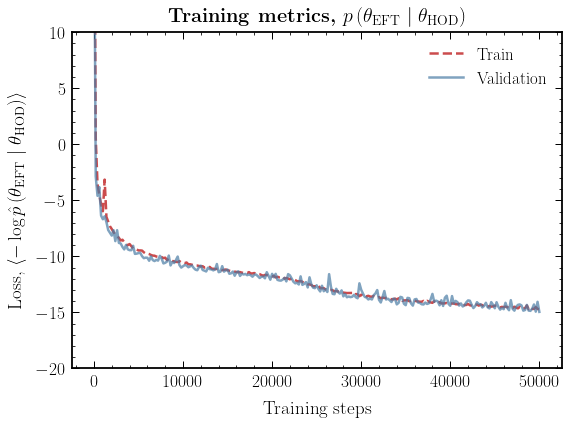

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(steps_accum, loss_train_accum, label="Train", ls='--')
ax.plot(steps_accum, loss_val_accum, label="Validation", alpha=0.7)
ax.set_xlabel("Training steps")
ax.set_ylabel(r"Loss, $\langle -\log \hat p\left(\theta_\mathrm{EFT}\mid\theta_\mathrm{HOD}\right)\rangle$")

ax.legend()
ax.set_title(r"\bf{Training metrics, $p\left(\theta_\mathrm{EFT}\mid\theta_\mathrm{HOD}\right)$}", y=1.01, fontsize=20)

ax.set_ylim(-20, 10)
plt.tight_layout()
plt.savefig("figures/loss_p_eft_hod.pdf")

In [224]:
samples_1 = flow.sample(context=(Y_val.mean(0) - 0 * Y_val.std(0)) [None, ...], num_samples=100_000)
samples_2 = flow.sample(context=(Y_val.mean(0) + 1 * Y_val.std(0)) [None, ...], num_samples=100_000)

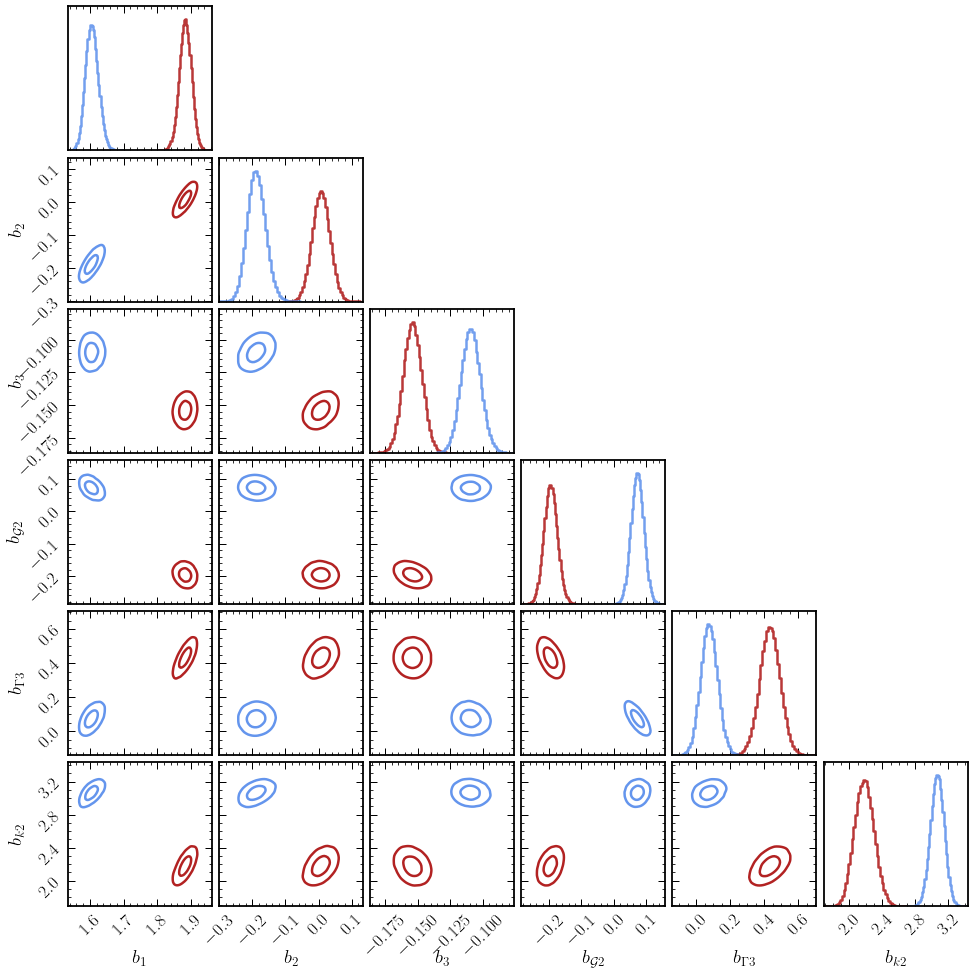

In [228]:
levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 1.,
    "smooth1d": 0.75,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": False,
    "labels": [r'$b_1$', r'$b_2$', r'$b_3$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$', r'$b_{k2}$']
}

fig = corner.corner(samples_1.detach().numpy(), **corner_configs, color='firebrick');
corner.corner(samples_2.detach().numpy(), **corner_configs, fig=fig, color='cornflowerblue');

In [229]:
torch.save(flow, "../data/models/p_beta_hod.pt")

## $p(\beta)$

In [180]:
d_in = X_train.shape[-1]

flow = get_flow(d_in=d_in, d_context=0, d_hidden=64, n_layers=6, dropout=0.1)
steps_accum, loss_train_accum, loss_val_accum = train_flow(flow, X_train, None, X_val, None, batch_size=128, n_steps=30001, n_eval_every=200, lr=3e-4)

/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
  0%|          | 25/30001 [00:00<04:06, 121.78it/s]

Step 0, loss: 19.01, val loss: 18.83


  1%|          | 218/30001 [00:01<03:27, 143.24it/s]

Step 200, loss: 6.22, val loss: -0.48


  1%|▏         | 428/30001 [00:03<03:29, 140.91it/s]

Step 400, loss: -1.59, val loss: -2.05


  2%|▏         | 623/30001 [00:04<03:32, 137.95it/s]

Step 600, loss: -2.46, val loss: -2.50


  3%|▎         | 829/30001 [00:05<03:23, 143.61it/s]

Step 800, loss: -2.67, val loss: -2.75


  3%|▎         | 1025/30001 [00:07<03:21, 143.95it/s]

Step 1000, loss: -2.84, val loss: -2.88


  4%|▍         | 1220/30001 [00:08<03:26, 139.71it/s]

Step 1200, loss: -2.92, val loss: -2.95


  5%|▍         | 1414/30001 [00:10<03:34, 133.37it/s]

Step 1400, loss: -3.03, val loss: -3.05


  5%|▌         | 1622/30001 [00:11<03:25, 138.18it/s]

Step 1600, loss: -3.05, val loss: -3.11


  6%|▌         | 1826/30001 [00:13<03:29, 134.25it/s]

Step 1800, loss: -3.11, val loss: -3.20


  7%|▋         | 2027/30001 [00:14<03:33, 131.20it/s]

Step 2000, loss: -3.15, val loss: -3.18


  7%|▋         | 2227/30001 [00:15<03:25, 135.35it/s]

Step 2200, loss: -3.22, val loss: -3.10


  8%|▊         | 2424/30001 [00:17<03:19, 138.12it/s]

Step 2400, loss: -3.24, val loss: -3.25


  9%|▊         | 2620/30001 [00:18<03:13, 141.16it/s]

Step 2600, loss: -3.26, val loss: -3.31


  9%|▉         | 2815/30001 [00:20<03:12, 140.93it/s]

Step 2800, loss: -3.30, val loss: -3.29


 10%|█         | 3024/30001 [00:21<03:28, 129.16it/s]

Step 3000, loss: -3.34, val loss: -3.38


 11%|█         | 3215/30001 [00:23<03:09, 141.27it/s]

Step 3200, loss: -3.36, val loss: -2.98


 11%|█▏        | 3426/30001 [00:24<03:03, 144.58it/s]

Step 3400, loss: -3.38, val loss: -3.45


 12%|█▏        | 3622/30001 [00:25<03:03, 143.78it/s]

Step 3600, loss: -3.41, val loss: -3.50


 13%|█▎        | 3816/30001 [00:27<03:23, 128.92it/s]

Step 3800, loss: -3.41, val loss: -3.46


 13%|█▎        | 4026/30001 [00:28<02:58, 145.58it/s]

Step 4000, loss: -3.45, val loss: -3.46


 14%|█▍        | 4222/30001 [00:30<03:00, 143.18it/s]

Step 4200, loss: -3.45, val loss: -3.52


 15%|█▍        | 4417/30001 [00:31<03:01, 140.96it/s]

Step 4400, loss: -3.50, val loss: -3.56


 15%|█▌        | 4628/30001 [00:33<02:54, 145.08it/s]

Step 4600, loss: -3.48, val loss: -3.54


 16%|█▌        | 4824/30001 [00:34<02:59, 140.47it/s]

Step 4800, loss: -3.47, val loss: -3.50


 17%|█▋        | 5017/30001 [00:35<02:56, 141.18it/s]

Step 5000, loss: -3.51, val loss: -3.42


 17%|█▋        | 5227/30001 [00:37<02:52, 143.55it/s]

Step 5200, loss: -3.55, val loss: -3.62


 18%|█▊        | 5422/30001 [00:38<02:50, 144.27it/s]

Step 5400, loss: -3.55, val loss: -3.57


 19%|█▊        | 5617/30001 [00:39<02:56, 138.37it/s]

Step 5600, loss: -3.54, val loss: -3.56


 19%|█▉        | 5828/30001 [00:41<02:49, 142.49it/s]

Step 5800, loss: -3.58, val loss: -3.54


 20%|██        | 6024/30001 [00:42<02:45, 144.58it/s]

Step 6000, loss: -3.57, val loss: -3.51


 21%|██        | 6220/30001 [00:44<02:44, 144.48it/s]

Step 6200, loss: -3.62, val loss: -3.65


 21%|██▏       | 6430/30001 [00:45<02:42, 144.61it/s]

Step 6400, loss: -3.63, val loss: -3.58


 22%|██▏       | 6625/30001 [00:46<02:41, 144.65it/s]

Step 6600, loss: -3.61, val loss: -3.64


 23%|██▎       | 6822/30001 [00:48<02:38, 146.20it/s]

Step 6800, loss: -3.63, val loss: -3.73


 23%|██▎       | 7021/30001 [00:49<02:39, 143.78it/s]

Step 7000, loss: -3.62, val loss: -3.67


 24%|██▍       | 7216/30001 [00:51<02:41, 141.08it/s]

Step 7200, loss: -3.63, val loss: -3.71


 25%|██▍       | 7426/30001 [00:52<02:39, 141.73it/s]

Step 7400, loss: -3.67, val loss: -3.69


 25%|██▌       | 7617/30001 [00:53<02:46, 134.49it/s]

Step 7600, loss: -3.68, val loss: -3.74


 26%|██▌       | 7821/30001 [00:55<02:37, 141.25it/s]

Step 7800, loss: -3.63, val loss: -3.60


 27%|██▋       | 8016/30001 [00:56<02:35, 141.13it/s]

Step 8000, loss: -3.67, val loss: -3.72


 27%|██▋       | 8226/30001 [00:58<02:33, 142.01it/s]

Step 8200, loss: -3.65, val loss: -3.77


 28%|██▊       | 8420/30001 [00:59<02:34, 139.54it/s]

Step 8400, loss: -3.68, val loss: -3.77


 29%|██▉       | 8629/30001 [01:01<02:29, 142.68it/s]

Step 8600, loss: -3.70, val loss: -3.70


 29%|██▉       | 8823/30001 [01:02<02:29, 142.12it/s]

Step 8800, loss: -3.69, val loss: -3.76


 30%|███       | 9019/30001 [01:03<02:26, 142.89it/s]

Step 9000, loss: -3.72, val loss: -3.82


 31%|███       | 9215/30001 [01:05<02:29, 139.41it/s]

Step 9200, loss: -3.71, val loss: -3.81


 31%|███▏      | 9415/30001 [01:06<02:37, 131.09it/s]

Step 9400, loss: -3.71, val loss: -3.79


 32%|███▏      | 9623/30001 [01:08<02:48, 120.97it/s]

Step 9600, loss: -3.66, val loss: -3.82


 33%|███▎      | 9820/30001 [01:09<02:27, 136.81it/s]

Step 9800, loss: -3.74, val loss: -3.79


 33%|███▎      | 10026/30001 [01:11<02:23, 139.42it/s]

Step 10000, loss: -3.73, val loss: -3.61


 34%|███▍      | 10219/30001 [01:12<02:19, 141.77it/s]

Step 10200, loss: -3.71, val loss: -3.86


 35%|███▍      | 10429/30001 [01:14<02:15, 144.95it/s]

Step 10400, loss: -3.74, val loss: -3.80


 35%|███▌      | 10624/30001 [01:15<02:18, 140.32it/s]

Step 10600, loss: -3.75, val loss: -3.71


 36%|███▌      | 10818/30001 [01:17<02:26, 131.21it/s]

Step 10800, loss: -3.72, val loss: -3.84


 37%|███▋      | 11027/30001 [01:18<02:14, 140.92it/s]

Step 11000, loss: -3.76, val loss: -3.74


 37%|███▋      | 11222/30001 [01:19<02:10, 143.66it/s]

Step 11200, loss: -3.79, val loss: -3.88


 38%|███▊      | 11416/30001 [01:21<02:12, 139.99it/s]

Step 11400, loss: -3.77, val loss: -3.74


 39%|███▉      | 11626/30001 [01:22<02:07, 144.62it/s]

Step 11600, loss: -3.79, val loss: -3.85


 39%|███▉      | 11815/30001 [01:24<02:15, 133.82it/s]

Step 11800, loss: -3.80, val loss: -3.85


 40%|████      | 12026/30001 [01:25<02:04, 144.48it/s]

Step 12000, loss: -3.76, val loss: -3.86


 41%|████      | 12221/30001 [01:26<02:20, 126.59it/s]

Step 12200, loss: -3.79, val loss: -3.87


 41%|████▏     | 12427/30001 [01:28<02:09, 135.61it/s]

Step 12400, loss: -3.79, val loss: -3.88


 42%|████▏     | 12621/30001 [01:29<02:02, 142.16it/s]

Step 12600, loss: -3.78, val loss: -3.85


 43%|████▎     | 12816/30001 [01:31<02:01, 142.02it/s]

Step 12800, loss: -3.81, val loss: -3.87


 43%|████▎     | 13025/30001 [01:32<02:02, 138.30it/s]

Step 13000, loss: -3.81, val loss: -3.83


 44%|████▍     | 13224/30001 [01:34<02:07, 131.65it/s]

Step 13200, loss: -3.81, val loss: -3.87


 45%|████▍     | 13423/30001 [01:35<01:57, 140.90it/s]

Step 13400, loss: -3.81, val loss: -3.87


 45%|████▌     | 13619/30001 [01:37<01:51, 146.44it/s]

Step 13600, loss: -3.81, val loss: -3.77


 46%|████▌     | 13830/30001 [01:38<01:51, 144.96it/s]

Step 13800, loss: -3.84, val loss: -3.93


 47%|████▋     | 14027/30001 [01:39<01:51, 142.77it/s]

Step 14000, loss: -3.82, val loss: -3.88


 47%|████▋     | 14222/30001 [01:41<01:48, 146.08it/s]

Step 14200, loss: -3.84, val loss: -3.87


 48%|████▊     | 14419/30001 [01:42<01:47, 145.62it/s]

Step 14400, loss: -3.83, val loss: -3.92


 49%|████▉     | 14630/30001 [01:44<01:47, 143.42it/s]

Step 14600, loss: -3.88, val loss: -3.82


 49%|████▉     | 14818/30001 [01:45<01:56, 130.01it/s]

Step 14800, loss: -3.85, val loss: -3.90


 50%|█████     | 15014/30001 [01:46<01:54, 130.54it/s]

Step 15000, loss: -3.82, val loss: -3.94


 51%|█████     | 15216/30001 [01:48<01:53, 130.32it/s]

Step 15200, loss: -3.81, val loss: -3.94


 51%|█████▏    | 15411/30001 [01:49<01:47, 135.51it/s]

Step 15400, loss: -3.87, val loss: -3.92


 52%|█████▏    | 15629/30001 [01:51<01:40, 143.48it/s]

Step 15600, loss: -3.88, val loss: -3.91


 53%|█████▎    | 15817/30001 [01:52<01:36, 147.35it/s]

Step 15800, loss: -3.87, val loss: -3.87


 53%|█████▎    | 16022/30001 [01:54<01:43, 134.57it/s]

Step 16000, loss: -3.82, val loss: -3.97


 54%|█████▍    | 16229/30001 [01:55<01:35, 143.90it/s]

Step 16200, loss: -3.88, val loss: -3.93


 55%|█████▍    | 16424/30001 [01:56<01:34, 143.73it/s]

Step 16400, loss: -3.90, val loss: -3.90


 55%|█████▌    | 16620/30001 [01:58<01:35, 139.98it/s]

Step 16600, loss: -3.88, val loss: -3.84


 56%|█████▌    | 16830/30001 [01:59<01:30, 145.62it/s]

Step 16800, loss: -3.84, val loss: -3.66


 57%|█████▋    | 17026/30001 [02:01<01:29, 145.43it/s]

Step 17000, loss: -3.88, val loss: -3.94


 57%|█████▋    | 17222/30001 [02:02<01:27, 145.28it/s]

Step 17200, loss: -3.90, val loss: -3.90


 58%|█████▊    | 17417/30001 [02:03<01:26, 145.10it/s]

Step 17400, loss: -3.88, val loss: -3.97


 59%|█████▉    | 17629/30001 [02:05<01:24, 146.41it/s]

Step 17600, loss: -3.91, val loss: -3.96


 59%|█████▉    | 17825/30001 [02:06<01:25, 142.34it/s]

Step 17800, loss: -3.89, val loss: -3.99


 60%|██████    | 18019/30001 [02:08<01:28, 135.54it/s]

Step 18000, loss: -3.89, val loss: -3.85


 61%|██████    | 18219/30001 [02:09<01:32, 126.73it/s]

Step 18200, loss: -3.90, val loss: -3.93


 61%|██████▏   | 18426/30001 [02:11<01:30, 127.60it/s]

Step 18400, loss: -3.92, val loss: -3.99


 62%|██████▏   | 18619/30001 [02:12<01:25, 133.14it/s]

Step 18600, loss: -3.93, val loss: -3.91


 63%|██████▎   | 18828/30001 [02:14<01:19, 140.00it/s]

Step 18800, loss: -3.94, val loss: -4.02


 63%|██████▎   | 19026/30001 [02:15<01:17, 140.97it/s]

Step 19000, loss: -3.90, val loss: -3.96


 64%|██████▍   | 19223/30001 [02:16<01:13, 146.30it/s]

Step 19200, loss: -3.92, val loss: -3.92


 65%|██████▍   | 19421/30001 [02:18<01:12, 145.64it/s]

Step 19400, loss: -3.91, val loss: -3.99


 65%|██████▌   | 19617/30001 [02:19<01:11, 145.04it/s]

Step 19600, loss: -3.92, val loss: -3.91


 66%|██████▌   | 19817/30001 [02:20<01:09, 147.53it/s]

Step 19800, loss: -3.96, val loss: -3.99


 67%|██████▋   | 20031/30001 [02:22<01:07, 147.39it/s]

Step 20000, loss: -3.93, val loss: -3.98


 67%|██████▋   | 20216/30001 [02:23<01:07, 144.07it/s]

Step 20200, loss: -3.94, val loss: -3.91


 68%|██████▊   | 20428/30001 [02:24<01:05, 145.98it/s]

Step 20400, loss: -3.96, val loss: -4.04


 69%|██████▉   | 20627/30001 [02:26<01:04, 144.88it/s]

Step 20600, loss: -3.96, val loss: -3.91


 69%|██████▉   | 20824/30001 [02:27<01:08, 133.13it/s]

Step 20800, loss: -3.94, val loss: -4.02


 70%|███████   | 21018/30001 [02:29<01:01, 144.90it/s]

Step 21000, loss: -3.95, val loss: -3.93


 71%|███████   | 21228/30001 [02:30<01:02, 139.98it/s]

Step 21200, loss: -3.93, val loss: -3.94


 71%|███████▏  | 21426/30001 [02:31<00:58, 146.97it/s]

Step 21400, loss: -3.97, val loss: -3.99


 72%|███████▏  | 21622/30001 [02:33<00:59, 140.90it/s]

Step 21600, loss: -3.94, val loss: -4.04


 73%|███████▎  | 21815/30001 [02:34<01:00, 135.81it/s]

Step 21800, loss: -3.98, val loss: -3.99


 73%|███████▎  | 22022/30001 [02:36<00:56, 140.58it/s]

Step 22000, loss: -3.98, val loss: -4.02


 74%|███████▍  | 22220/30001 [02:37<00:53, 145.36it/s]

Step 22200, loss: -3.89, val loss: -4.06


 75%|███████▍  | 22418/30001 [02:38<00:52, 145.71it/s]

Step 22400, loss: -3.96, val loss: -3.96


 75%|███████▌  | 22629/30001 [02:40<00:53, 138.80it/s]

Step 22600, loss: -3.96, val loss: -3.88


 76%|███████▌  | 22824/30001 [02:41<00:50, 142.21it/s]

Step 22800, loss: -3.96, val loss: -4.07


 77%|███████▋  | 23028/30001 [02:43<00:50, 136.79it/s]

Step 23000, loss: -4.00, val loss: -4.02


 77%|███████▋  | 23227/30001 [02:44<00:47, 141.75it/s]

Step 23200, loss: -3.99, val loss: -4.01


 78%|███████▊  | 23423/30001 [02:46<00:46, 140.75it/s]

Step 23400, loss: -3.95, val loss: -4.04


 79%|███████▊  | 23619/30001 [02:47<00:44, 143.32it/s]

Step 23600, loss: -3.97, val loss: -4.00


 79%|███████▉  | 23817/30001 [02:48<00:43, 141.32it/s]

Step 23800, loss: -3.99, val loss: -4.05


 80%|████████  | 24030/30001 [02:50<00:40, 146.66it/s]

Step 24000, loss: -3.99, val loss: -4.06


 81%|████████  | 24230/30001 [02:51<00:39, 146.34it/s]

Step 24200, loss: -4.02, val loss: -4.02


 81%|████████▏ | 24426/30001 [02:52<00:40, 136.54it/s]

Step 24400, loss: -4.02, val loss: -4.00


 82%|████████▏ | 24620/30001 [02:54<00:37, 143.17it/s]

Step 24600, loss: -4.02, val loss: -3.97


 83%|████████▎ | 24830/30001 [02:55<00:36, 143.02it/s]

Step 24800, loss: -4.01, val loss: -4.03


 83%|████████▎ | 25025/30001 [02:57<00:37, 131.66it/s]

Step 25000, loss: -4.04, val loss: -4.00


 84%|████████▍ | 25220/30001 [02:58<00:34, 139.82it/s]

Step 25200, loss: -4.03, val loss: -4.08


 85%|████████▍ | 25430/30001 [03:00<00:32, 142.21it/s]

Step 25400, loss: -4.01, val loss: -4.10


 85%|████████▌ | 25625/30001 [03:01<00:31, 141.16it/s]

Step 25600, loss: -3.99, val loss: -4.10


 86%|████████▌ | 25821/30001 [03:02<00:28, 144.20it/s]

Step 25800, loss: -4.05, val loss: -4.05


 87%|████████▋ | 26017/30001 [03:04<00:27, 145.35it/s]

Step 26000, loss: -4.02, val loss: -4.04


 87%|████████▋ | 26228/30001 [03:05<00:26, 143.82it/s]

Step 26200, loss: -4.01, val loss: -4.08


 88%|████████▊ | 26422/30001 [03:06<00:25, 137.99it/s]

Step 26400, loss: -4.00, val loss: -4.03


 89%|████████▊ | 26616/30001 [03:08<00:23, 142.32it/s]

Step 26600, loss: -4.01, val loss: -3.91


 89%|████████▉ | 26827/30001 [03:09<00:22, 140.75it/s]

Step 26800, loss: -4.03, val loss: -3.99


 90%|█████████ | 27019/30001 [03:11<00:21, 141.36it/s]

Step 27000, loss: -4.01, val loss: -4.00


 91%|█████████ | 27230/30001 [03:12<00:19, 143.93it/s]

Step 27200, loss: -4.04, val loss: -4.07


 91%|█████████▏| 27425/30001 [03:13<00:18, 140.37it/s]

Step 27400, loss: -4.06, val loss: -4.09


 92%|█████████▏| 27620/30001 [03:15<00:16, 140.21it/s]

Step 27600, loss: -4.03, val loss: -3.89


 93%|█████████▎| 27830/30001 [03:16<00:15, 142.28it/s]

Step 27800, loss: -4.01, val loss: -4.08


 93%|█████████▎| 28019/30001 [03:18<00:14, 138.80it/s]

Step 28000, loss: -4.05, val loss: -4.14


 94%|█████████▍| 28228/30001 [03:19<00:12, 141.18it/s]

Step 28200, loss: -4.08, val loss: -4.02


 95%|█████████▍| 28427/30001 [03:21<00:12, 129.92it/s]

Step 28400, loss: -4.02, val loss: -4.10


 95%|█████████▌| 28617/30001 [03:22<00:09, 143.67it/s]

Step 28600, loss: -4.03, val loss: -4.06


 96%|█████████▌| 28831/30001 [03:23<00:08, 144.48it/s]

Step 28800, loss: -4.01, val loss: -4.08


 97%|█████████▋| 29025/30001 [03:25<00:07, 136.27it/s]

Step 29000, loss: -4.06, val loss: -4.03


 97%|█████████▋| 29217/30001 [03:26<00:05, 142.67it/s]

Step 29200, loss: -4.06, val loss: -4.12


 98%|█████████▊| 29427/30001 [03:28<00:03, 143.77it/s]

Step 29400, loss: -4.08, val loss: -4.02


 99%|█████████▊| 29621/30001 [03:29<00:02, 131.51it/s]

Step 29600, loss: -4.06, val loss: -4.08


 99%|█████████▉| 29830/30001 [03:31<00:01, 142.91it/s]

Step 29800, loss: -4.03, val loss: -4.09


100%|██████████| 30001/30001 [03:32<00:00, 141.31it/s]

Step 30000, loss: -4.06, val loss: -4.09


In [181]:
flow.eval();

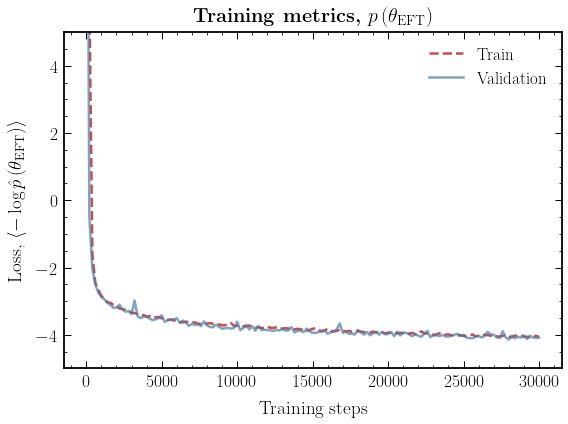

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(steps_accum, loss_train_accum, label="Train", ls='--')
ax.plot(steps_accum, loss_val_accum, label="Validation", alpha=0.7)
ax.set_xlabel("Training steps")
ax.set_ylabel(r"Loss, $\langle -\log \hat p\left(\theta_\mathrm{EFT}\right)\rangle$")

ax.legend()
ax.set_title(r"\bf{Training metrics, $p\left(\theta_\mathrm{EFT}\right)$}", y=1.01, fontsize=20)

ax.set_ylim(-5, 5)

plt.tight_layout()
plt.savefig("figures/loss_p_eft.pdf")

In [183]:
samples = flow.sample(num_samples=100_000)

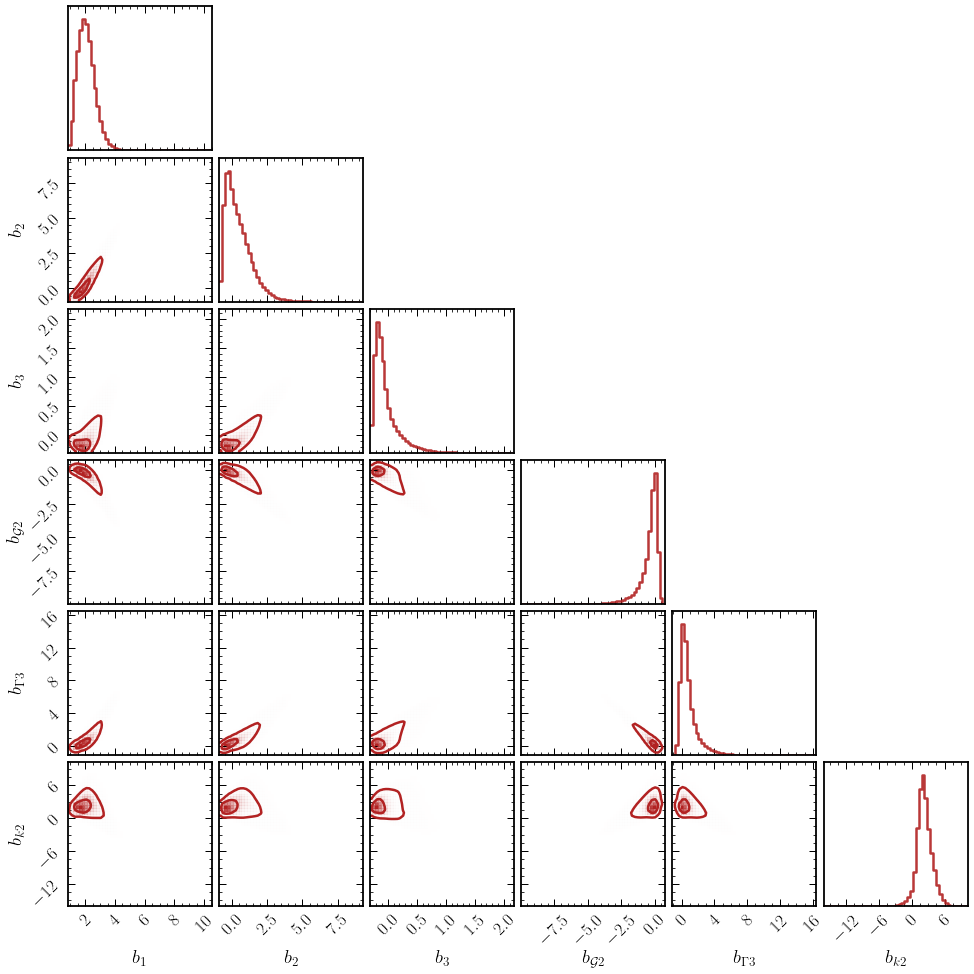

In [184]:
levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 0.75,
    "smooth1d": 0.5,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": True,
    "labels": [r'$b_1$', r'$b_2$', r'$b_3$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$', r'$b_{k2}$']
}

fig = corner.corner(samples.detach().numpy(), **corner_configs, color='firebrick');

In [185]:
torch.save(flow, "../data/models/p_beta.pt")